In [1]:
import tarfile
import numpy as np
import matplotlib.pyplot as plt

# Power Model - on Worker node [192.168.58.68]

## Experiment Setup
```
### Config: [TurboBoostOn.HyperThreadOn, TurboBoostOff.HyperThreadOff]
### Iterations: 3
### Number CPUs: TurboBoostOn.HyperThreadOn -> [1 - 32], TurboBoostOff.HyperThreadOff-> [1 - 16]
### Workload: stress-ng --matrix $i -t 60s
```

## Experiment Run
```
For each Iterations, and Config above, I ran stress-ng for 60 seconds each with a different number of CPUs increasing from 1 to 32 or 16, depending on the Config. As it is running, I collected the power measurement using this tool: https://github.com/handong32/rapl-service, which spills the per package CPU and DRAM power reading into a file. Figures below are the result of this experiment.
```

In [2]:
def plot(axs, combofig):
    # Plot data on each subplot
    for i, ax in enumerate(axs.flat):
        print(combofig[i])
    
        iter=combofig[i][0]
        tbht=combofig[i][1]
        ncpus=combofig[i][2]
        
        x = []
        ycpu = []
        ycpu_std = []
        ydram = []
        ydram_std = []
        for ncpu in range(1, ncpus+1):
            fname = f"stress-ng.iter{iter}.numcpus{ncpu}.{tbht}.matrix.60"
            print(f"🟢 🟢 Reading {fname} 🟢 🟢")
            f=tar.extractfile(fname)
            content=f.read()
            decoded_content = content.decode("utf-8")
            cpupkgs=[]
            drampkgs=[]
            for line in decoded_content.split("\n"):
                if len(line) > 0:
                    ll = line.split(" ")
                    if float(ll[0]) > 0.0 and float(ll[1]) > 0.0:
                        cpupkgs.append(float(ll[0]))
                        drampkgs.append(float(ll[1]))
            print(np.mean(np.array(cpupkgs)), np.std(np.array(cpupkgs)))
            x.append(ncpu)
            ycpu.append(np.mean(np.array(cpupkgs)))
            ycpu_std.append(np.std(np.array(cpupkgs)))
            ydram.append(np.mean(np.array(drampkgs)))
            ydram_std.append(np.std(np.array(drampkgs)))
        ax.errorbar(x, ycpu, yerr=ycpu_std, fmt='x', capsize=1, label="CPU Package")
        ax.errorbar(x, ydram, yerr=ydram_std, fmt='o', capsize=1, label="DRAM Package")
        ax.set_xlabel('Matrix Instances')
        ax.set_ylabel('Mean Package Power (W)')
        ax.set_ylim(bottom=0, top=200)
        ax.set_title(f"Iteration [{iter+1}], {tbht}, \n stress-ng --matrix -t 60s")
        ax.grid(True)
        ax.legend()
        #plt.show()
        
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
tar = tarfile.open("/users/gustinj/results/stress-ng-results.tar.gz")


[0, 'TurboOn.HyperThreadOn', 32]
🟢 🟢 Reading stress-ng.iter0.numcpus1.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
44.855769775862065 0.2785956468310454
🟢 🟢 Reading stress-ng.iter0.numcpus2.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
50.23953346551723 1.8953527161016779
🟢 🟢 Reading stress-ng.iter0.numcpus3.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
65.60773142857143 3.3122399324843124
🟢 🟢 Reading stress-ng.iter0.numcpus4.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
68.1959765862069 2.9953860071345306
🟢 🟢 Reading stress-ng.iter0.numcpus5.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
80.92659368965516 2.149805546077247
🟢 🟢 Reading stress-ng.iter0.numcpus6.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
90.2982093275862 2.2096117572611096
🟢 🟢 Reading stress-ng.iter0.numcpus7.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
94.69721198275862 3.1121373715796095
🟢 🟢 Reading stress-ng.iter0.numcpus8.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
100.14693170689655 2.935247365055228
🟢 🟢 Reading stress-ng.iter0.numcpus9.TurboOn.HyperThreadOn.matrix.60 🟢 🟢
104.093469086206

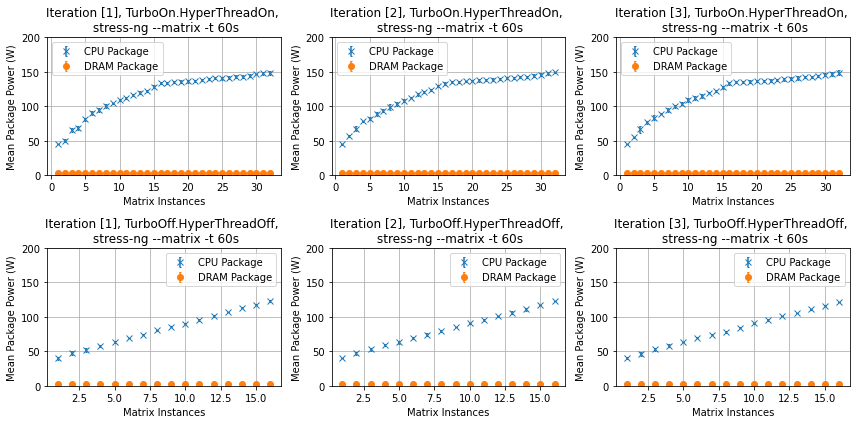

In [3]:
# Create a figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

combofig = {0: [0, "TurboOn.HyperThreadOn", 32], 1: [1, "TurboOn.HyperThreadOn", 32], 2: [2, "TurboOn.HyperThreadOn", 32],
           3: [0, "TurboOff.HyperThreadOff", 16], 4: [1, "TurboOff.HyperThreadOff", 16], 5: [2, "TurboOff.HyperThreadOff", 16]}

plot(axs, combofig)

# Analysis of figures above
```
1) Top 3 figures has TurboBoost and HyperThread ON, and bottom 3 figures has them disabled
2) The X-axis Mean Package Power (W), is averaged over a 60 second run of stress-ng with an increasing number of CPUs set. There is also standard deviation shown as y-error bars for each mean power measurement.
3) Overall, at maybe 15? CPUs we see the slope of the power decrease which probably means we are hitting the peak power that the node can support.
4) There is a difference in Power between the two Configs (see figures below), the slope with TurboBoost and HyperThreading on is steeper - perhaps the CPU frequency is boosted to support the stress-ng workload, we don't measure performance of stress-ng so its hard to say what is the performance-power trade-off in this scenario
```